   Element  ni  nj  Length_in  Axial_Force_kips  Stress_ksi
0        1   1   4    360.000             0.000      0.0000
1        2   2   5    360.000           -89.645    -89.6447
2        3   3   6    360.000            10.355     10.3553
3        4   1   2    360.000          -200.000   -200.0000
4        5   2   3    360.000            10.355     10.3553
5        6   4   5    360.000            -0.000     -0.0000
6        7   5   6    360.000            10.355     10.3553
7        8   2   4    509.117           282.843    282.8427
8        9   3   5    509.117           -14.645    -14.6447
9       10   2   6    509.117           -14.645    -14.6447


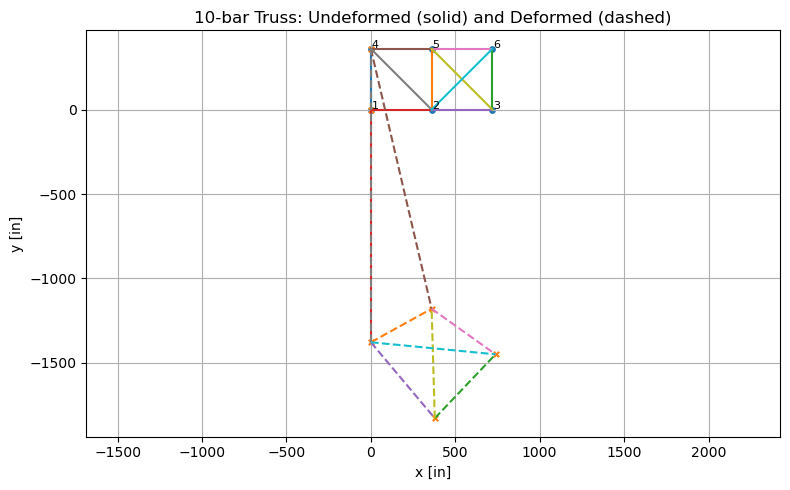


Resultados por barra salvos em 'truss_10bar_results.csv':
   Element  ni  nj  Length_in  Axial_Force_kips  Stress_ksi
0        1   1   4    360.000             0.000      0.0000
1        2   2   5    360.000           -89.645    -89.6447
2        3   3   6    360.000            10.355     10.3553
3        4   1   2    360.000          -200.000   -200.0000
4        5   2   3    360.000            10.355     10.3553
5        6   4   5    360.000            -0.000     -0.0000
6        7   5   6    360.000            10.355     10.3553
7        8   2   4    509.117           282.843    282.8427
8        9   3   5    509.117           -14.645    -14.6447
9       10   2   6    509.117           -14.645    -14.6447

Deslocamentos nodais salvos em 'truss_10bar_displacements.csv':
   Node     ux_in      uy_in
0     1  0.000000   0.000000
1     2 -7.200000 -27.564675
2     3 -6.827208 -36.564675
3     4  0.000000   0.000000
4     5 -0.000000 -30.791883
5     6  0.372792 -36.191883


In [5]:
# Finite Element Analysis of the classic 10-bar planar truss
# - 6 nodes, 10 bars
# - Supports: nodes 1 and 4 fixed in x and y
# - Loads: P_y = -100 kips at nodes 2 and 5
# - Material: E = 10,000 ksi
# - Cross-sectional area: A = 1.0 in^2 (uniform for all bars)
#
# We'll compute:
# - Nodal displacements
# - Member axial forces and stresses
# - Plot undeformed and deformed shapes
# - Table with results (forces/stresses) and a CSV for download

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
# from caas_jupyter_tools import display_dataframe_to_user

# Geometry (inches)
nodes = np.array([
    [0.0,   0.0],   # 1
    [360.0, 0.0],   # 2
    [720.0, 0.0],   # 3
    [0.0,   360.0], # 4
    [360.0, 360.0], # 5
    [720.0, 360.0], # 6
])

# Element connectivity (1-based node indices in comments)
# Classic 10-bar truss set
elements = np.array([
    [0, 3],  # (1-4) left vertical
    [1, 4],  # (2-5) middle vertical
    [2, 5],  # (3-6) right vertical
    [0, 1],  # (1-2) bottom left horiz
    [1, 2],  # (2-3) bottom right horiz
    [3, 4],  # (4-5) top left horiz
    [4, 5],  # (5-6) top right horiz
    [1, 3],  # (2-4) diag
    [2, 4],  # (3-5) diag
    [1, 5],  # (2-6) long diag
])

# Material properties
E = 10000.0  # ksi
A = 1.0      # in^2 (uniform)

ndof = nodes.shape[0] * 2  # 2 dof per node (ux, uy)

def element_stiffness_2d_truss(xi, yi, xj, yj, E, A):
    L = sqrt((xj - xi)**2 + (yj - yi)**2)
    c = (xj - xi) / L
    s = (yj - yi) / L
    k_local = (E * A / L) * np.array([
        [ c*c,  c*s, -c*c, -c*s],
        [ c*s,  s*s, -c*s, -s*s],
        [-c*c, -c*s,  c*c,  c*s],
        [-c*s, -s*s,  c*s,  s*s],
    ])
    return k_local, L, c, s

# Global stiffness assembly
K = np.zeros((ndof, ndof))
elem_lengths = []
elem_cs = []
for e, (ni, nj) in enumerate(elements):
    xi, yi = nodes[ni]
    xj, yj = nodes[nj]
    k_e, L, c, s = element_stiffness_2d_truss(xi, yi, xj, yj, E, A)
    elem_lengths.append(L)
    elem_cs.append((c, s))
    # DOF map
    dof_map = np.array([2*ni, 2*ni+1, 2*nj, 2*nj+1])
    # Assemble
    for a in range(4):
        for b in range(4):
            K[dof_map[a], dof_map[b]] += k_e[a, b]

elem_lengths = np.array(elem_lengths)
elem_cs = np.array(elem_cs)

# Load vector (kips). Downward 100 kips at nodes 2 and 5 (1-based), i.e., indices 1 and 4 (0-based)
F = np.zeros(ndof)
F[2*1 + 1] = -100.0  # Node 2, y
F[2*4 + 1] = -100.0  # Node 5, y

# Boundary conditions: Nodes 1 and 4 fixed in x,y (indices 0 and 3)
fixed_dofs = np.array([0, 1, 6, 7])  # (ux1, uy1, ux4, uy4)

all_dofs = np.arange(ndof)
free_dofs = np.setdiff1d(all_dofs, fixed_dofs)

# Solve K_ff u_f = F_f
K_ff = K[np.ix_(free_dofs, free_dofs)]
F_f = F[free_dofs]
u = np.zeros(ndof)
u[free_dofs] = np.linalg.solve(K_ff, F_f)

# Element axial forces and stresses
forces = []
stresses = []
for e, (ni, nj) in enumerate(elements):
    dof_map = np.array([2*ni, 2*ni+1, 2*nj, 2*nj+1])
    ue = u[dof_map]
    c, s = elem_cs[e]
    L = elem_lengths[e]
    # Axial strain = (1/L) * [-c, -s, c, s] · ue
    axial_strain = (1.0 / L) * (-c * ue[0] - s * ue[1] + c * ue[2] + s * ue[3])
    sigma = E * axial_strain  # ksi
    N = sigma * A             # kips (since sigma in ksi and A in in^2)
    stresses.append(sigma)
    forces.append(N)

forces = np.array(forces)
stresses = np.array(stresses)

# Prepare results table
elem_ids = np.arange(1, len(elements)+1)
df = pd.DataFrame({
    "Element": elem_ids,
    "ni": elements[:,0] + 1,  # back to 1-based
    "nj": elements[:,1] + 1,
    "Length_in": np.round(elem_lengths, 3),
    "Axial_Force_kips": np.round(forces, 3),
    "Stress_ksi": np.round(stresses, 4),
})

# Save CSV
csv_path = "/mnt/data/truss_10bar_results.csv"
print(df)           # mostra tabela no terminal
df.to_csv("saida.csv", index=False)  # salva em CSV


# Plot undeformed and deformed shape (single chart)
scale = 50.0  # deformation scale factor for visualization
xy = nodes.copy()
xy_def = nodes + scale * u.reshape((-1, 2))

plt.figure(figsize=(8, 5))
# Undeformed
for (ni, nj) in elements:
    x = [xy[ni, 0], xy[nj, 0]]
    y = [xy[ni, 1], xy[nj, 1]]
    plt.plot(x, y, linewidth=1.5)

# Deformed
for (ni, nj) in elements:
    x = [xy_def[ni, 0], xy_def[nj, 0]]
    y = [xy_def[ni, 1], xy_def[nj, 1]]
    plt.plot(x, y, linestyle='--', linewidth=1.5)

plt.scatter(xy[:,0], xy[:,1], s=15)
plt.scatter(xy_def[:,0], xy_def[:,1], s=15, marker='x')

for i, (x, y) in enumerate(xy, start=1):
    plt.text(x+5, y+5, f"{i}", fontsize=8)

plt.title("10-bar Truss: Undeformed (solid) and Deformed (dashed)")
plt.xlabel("x [in]")
plt.ylabel("y [in]")
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()

# Save nodal displacements as a table too
u_table = pd.DataFrame({
    "Node": np.arange(1, nodes.shape[0]+1),
    "ux_in": np.round(u[0::2], 6),
    "uy_in": np.round(u[1::2], 6),
})
# Resultados por barra
df.to_csv("truss_10bar_results.csv", index=False)
print("\nResultados por barra salvos em 'truss_10bar_results.csv':")
print(df)

# Deslocamentos nodais
u_table = pd.DataFrame({
    "Node": np.arange(1, nodes.shape[0]+1),
    "ux_in": np.round(u[0::2], 6),
    "uy_in": np.round(u[1::2], 6),
})
u_table.to_csv("truss_10bar_displacements.csv", index=False)
print("\nDeslocamentos nodais salvos em 'truss_10bar_displacements.csv':")
print(u_table)